In [2]:
import matplotlib.pyplot as plt
try:
    xrange = xrange
except:
    xrange = range
from PIL import ImageGrab
import cv2
import time
import math
import datetime
import random
import io
from lib.getkeys import key_check
from lib.reinforcement import Qnetwork,updateTarget,updateTargetGraph
from lib.SQL import SQLCalls
from sys import stdout
import sqlite3
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import os
from PIL import Image
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.models import Model,Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Conv2D, MaxPooling2D,concatenate, Flatten, GlobalAveragePooling2D
from keras.utils import to_categorical
SQL=SQLCalls()

Using TensorFlow backend.


In [6]:
def make_model():
    image_model_inputs = Input(shape=(580,580,3),dtype='float32',name='main_image')
    image_model=Conv2D(16, (2, 2), padding='valid', activation='relu')(image_model_inputs)
    image_model=Conv2D(16, (2, 2), padding='valid', activation='relu')(image_model)

    image_model=Conv2D(32, (1,1),strides=2, padding='valid', activation='relu')(image_model)
    image_model=Conv2D(32, (1,1),strides=2, padding='valid', activation='relu')(image_model)

    image_model=Conv2D(8, (1,1),strides=3, padding='same', activation='relu')(image_model)
    image_model=Conv2D(8, (1,1),strides=2, padding='same', activation='relu')(image_model)
    
    image_model=Flatten()(image_model)
    
    gene_model_inputs = Input(shape=(13,13,12),dtype='float32',name='gene_image')
    gene_model=Conv2D(16, (2, 2), padding='valid', activation='relu')(gene_model_inputs)
    gene_model=Conv2D(16, (2, 2), padding='valid', activation='relu')(gene_model)
    
   # gene_model=Conv2D(8, (1,1),strides=3, padding='same', activation='relu')(gene_model)
    #gene_model=Conv2D(8, (1,1),strides=2, padding='same', activation='relu')(gene_model)
    
    gene_model=Flatten()(gene_model)
    
    combined_model=concatenate([image_model,gene_model])
    
    combined_model=Dense(32, activation='relu')(combined_model)
    combined_model=Dense(8, activation='relu')(combined_model)
    combined_model_preditions=Dense(2, activation='softmax')(combined_model)
    model=Model(inputs=[image_model_inputs,gene_model_inputs],outputs=combined_model_preditions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
model=make_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_image (InputLayer)          (None, 580, 580, 3)   0                                            
____________________________________________________________________________________________________
conv2d_9 (Conv2D)                (None, 579, 579, 16)  208         main_image[0][0]                 
____________________________________________________________________________________________________
conv2d_10 (Conv2D)               (None, 578, 578, 16)  1040        conv2d_9[0][0]                   
____________________________________________________________________________________________________
conv2d_11 (Conv2D)               (None, 289, 289, 32)  544         conv2d_10[0][0]                  
___________________________________________________________________________________________

In [7]:
model = load_model('dqn_frozen_model.h5')

In [8]:
def setup_genomes():
    BoxRadius=6
    BoxLength=BoxRadius*2+1
    BoxArea=(BoxLength)*(BoxLength)
    gene_image=np.empty([len(Genomes),BoxLength,BoxLength,12])
    gene_image.fill(0)
    BUTTON_AMOUNT=6
    for Genome_Num,Genome in enumerate(Genomes):
        for gene in Genome:
            genome_type=0
            #print(gene[0],Genome_Num,BoxArea*2)
            if gene[0]<BoxArea:
                pass
                #print("Normal Input")
            elif gene[0]>BoxArea*2:    
                #print("bias")
                continue
            else:
                pass
               # print("Inverse Input")
                genome_type+=BUTTON_AMOUNT
            genome_type+=int(gene[1]-1000001) 
            if genome_type>=0:
                # print ,Y,Type(Type of Input,Button Pressed)
                gene_image[Genome_Num][int(gene[0]%(BoxArea)//BoxLength)][int(gene[0]%(BoxArea)%13)][genome_type]=gene[2] 
    return gene_image
Genomes=SQL.GatherGenomes()
gene_images=setup_genomes()

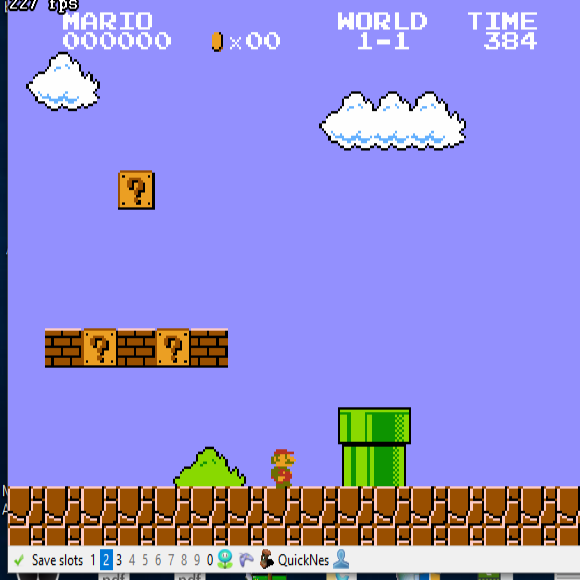

In [101]:
def adapt_array(arr):
    """
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())
def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("array", convert_array)

con=sqlite3.connect('DQN.db', detect_types=sqlite3.PARSE_DECLTYPES,isolation_level=None)
cur = con.cursor()
cur.execute("PRAGMA synchronous = OFF;")
cur.execute("PRAGMA journal_mode=WAL;")
cur.execute("PRAGMA read_uncommitted = true;")
cur.execute("SELECT GenomeNum,Gene,GeneContent FROM Genes ORDER BY Genome,Gene")
sql = '''Select image
        from example_images
        WHERE score=0 and GenomeKey like '%90%' LIMIT 1'''
cur.execute(sql)
results=np.array(cur.fetchone())[0]
cur.execute("PRAGMA synchronous = OFF;")
cur.execute("PRAGMA journal_mode=WAL;")
cur.execute("PRAGMA read_uncommitted = true;")
cur.execute("SELECT GenomeNum,Gene,GeneContent FROM Genes ORDER BY Genome,Gene")
sql = '''Select geneimage
        from example_genes where GenomeKey like '%05:43:07.450%' LIMIT 32'''
cur.execute(sql)
results2=np.array(cur.fetchall()).reshape([32,13,13,12])
Image.fromarray(results,'RGB')

In [106]:
image_duplicated=np.tile(Images[0], (32,1,1,1))
print(image_duplicated.shape)
print(results2.shape)
history=model.predict([image_duplicated,results2],batch_size=16)
print(np.sum(history[:,0]))
print(np.sum(history[:,1]))
print(max(history[:,0]))
print(history)



(32, 580, 580, 3)
(32, 13, 13, 12)
31.9975
0.00250412
0.999988
[[  9.99965072e-01   3.48769354e-05]
 [  9.99978304e-01   2.17126544e-05]
 [  9.99951720e-01   4.82451469e-05]
 [  9.99879837e-01   1.20166835e-04]
 [  9.99865055e-01   1.34916205e-04]
 [  9.99965787e-01   3.41596096e-05]
 [  9.99942303e-01   5.77504761e-05]
 [  9.99942183e-01   5.78360123e-05]
 [  9.99957919e-01   4.21305376e-05]
 [  9.99930978e-01   6.89873632e-05]
 [  9.99927878e-01   7.21514079e-05]
 [  9.99964118e-01   3.58832258e-05]
 [  9.99920249e-01   7.97628672e-05]
 [  9.99943137e-01   5.68704781e-05]
 [  9.99946833e-01   5.31522674e-05]
 [  9.99918938e-01   8.10831552e-05]
 [  9.99920011e-01   8.00017442e-05]
 [  9.99875188e-01   1.24749335e-04]
 [  9.99941111e-01   5.88983094e-05]
 [  9.99958754e-01   4.12819427e-05]
 [  9.99986410e-01   1.35422506e-05]
 [  9.99911785e-01   8.82560344e-05]
 [  9.99956846e-01   4.31718108e-05]
 [  9.99931455e-01   6.85156483e-05]
 [  9.99648213e-01   3.51783849e-04]
 [  9.999380

In [109]:
Images=[]
for i in range(150):
    sql = '''Select image
            from example_images
            WHERE id=? LIMIT 1'''
    cur.execute(sql,(i+1,))
    results=np.array(cur.fetchone())[0]
    image_duplicated=np.tile(results, (32,1,1,1))
    history=model.predict([image_duplicated,results2],batch_size=16)
    if np.sum(history[:,0])>2 and np.sum(history[:,0])<30:
        print(len(Images),np.sum(history[:,0]))
        Images.append(results)

0 4.4033
1 28.8152
2 2.85391
3 25.6821
4 26.4166
5 28.4057
6 10.7124


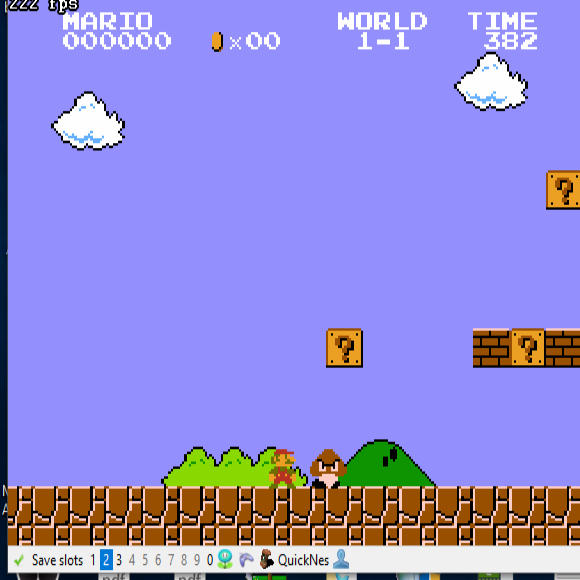

In [111]:
Image.fromarray(Images[2],'RGB')